# BE noté -- Fondations statistiques du Machine Learning

Cet devoir noté est composé de deux exercices. Il sera idéalement réalisé en binome et éventuellement seul. Les réponses seront données dans un notebook qui indiquera clairement les **noms et prénoms des élèves** l'ayant realisé.


<div class="alert alert-info">
Ce notebook contient le BE réalisé par ACCOU Martin.
<div>

## Exercice 1

- Le produit semble-t-il avoir un effet ?
Nous souhaitons évaluer si un nouveau produit a un effet significatif sur le rendement de moteurs. Pour y répondre, ce rendement (*Efficiency*) a été mesuré sur deux types de moteurs (*Brand_1* et *Brand_2*) et en testant différents niveaux de concentration (*Concentration*) du produit. Les observations sont dans le fichier *Efficiency_Observations.csv* A l'aide de modèles de régression linéaire et de tests statistiques, nous allons alors évaluer :
- Cet effet est-il différent en fonction de la marque du moteur ?
- Cet effet dépend-il de la concentration du produit ?

Afin de résoudre le problème, deux hypothèses seront effectuées :
- Pour chaque marque de moteur, la relation entre la concentration et le rendement est supposée linéaire.
- La distribution des erreurs de ce modèle est supposée suivre une loi Normale centrée.


La démarche pour répondre à ces questions sera commentée dans le notebook rendu, quels qu'en soient ses résultats.


Conseil : Avant de définir une stratégie de résolution, il est recommandé de visualiser les données de *Efficiency_Observations.csv* en distinguant bien les observations obtenues dans les groupes *Brand_1* et *Brand_2*.



In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bartlett, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [9]:
dataframe=pd.read_csv("./Efficiency_Observations.csv",sep=',')
dataframe.head()

,Brand,Concentration,Efficiency
0,Brand_1,3.9479,3.2224
1,Brand_1,1.7838,1.5127
2,Brand_1,7.4415,4.3736
3,Brand_1,8.5625,5.2151
4,Brand_1,9.8002,5.4256


<div class="alert alert-info">
On applique les recommandations du sujet, et on visualise les données en distinguant les deux groupes.
<div>

Text(0, 0.5, 'Efficiency')

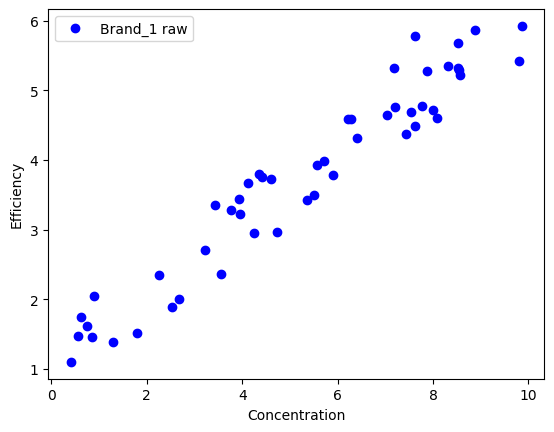

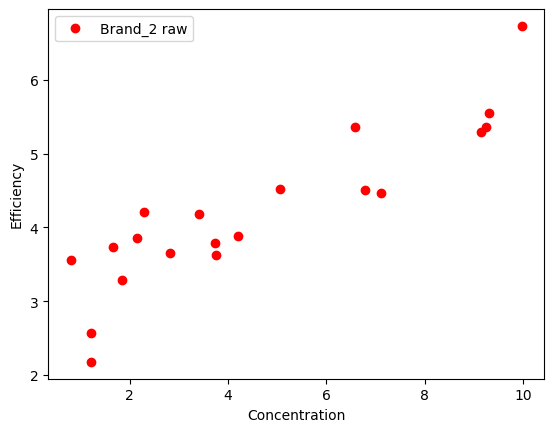

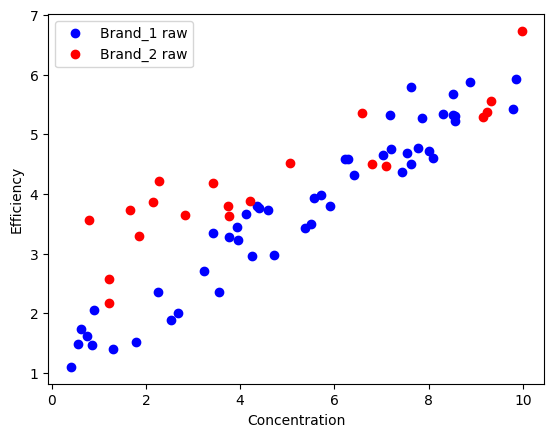

In [10]:
dataframe_brand_1 = dataframe.loc[dataframe['Brand'] == 'Brand_1']
dataframe_brand_2 = dataframe.loc[dataframe['Brand'] == 'Brand_2']

ax1 = dataframe_brand_1.plot(x='Concentration', y='Efficiency', style='o', label='Brand_1 raw', color='blue')
ax1.set_ylabel("Efficiency")

ax2 = dataframe_brand_2.plot(x='Concentration', y='Efficiency', style='o', label='Brand_2 raw', color='red')
ax2.set_ylabel("Efficiency")

ax3 = dataframe_brand_1.plot(x='Concentration', y='Efficiency', style='o', label='Brand_1 raw', color='blue')
dataframe_brand_2.plot(x='Concentration', y='Efficiency', style='o', label='Brand_2 raw', color='red', ax=ax3)
ax3.set_ylabel("Efficiency")

<div class="alert alert-info">
On voit bien que la première hypothèse est justifiée, puisqu'une tendance linéaire se dessine pour chacune des deux marques de moteur.

En réponse à la question 1, le fait que le rendement soit strictement supérieur à 1 pour l'entièreté des échantillons nous garantit que le produit semble avoir un effet, ce que confirment clairement les graphes.

Pour répondre aux questions suivantes, nous devons mener une étude plus avancée des données disponibles.
On remarque que les données ne présentent pas d'outliers notables, on peut donc se contenter d'une régression linéaire classique par moindre carrés, également motivée par la gaussianité de la distribution des résidus.

On remarque aussi et surtout avec le troisième graphe que la différence entre les deux nuages de points des deux marques n'est pas clairement distincte à première vue.<div>

In [11]:
# Modèle de régression linéaire pour Brand_1
X_brand_1 = dataframe_brand_1[['Concentration']]
y_brand_1 = dataframe_brand_1['Efficiency']
model_brand_1 = LinearRegression().fit(X_brand_1, y_brand_1)
y_pred_brand_1 = model_brand_1.predict(X_brand_1)

# Modèle de régression linéaire pour Brand_2
X_brand_2 = dataframe_brand_2[['Concentration']]
y_brand_2 = dataframe_brand_2['Efficiency']
model_brand_2 = LinearRegression().fit(X_brand_2, y_brand_2)
y_pred_brand_2 = model_brand_2.predict(X_brand_2)

<div class="alert alert-info">
Traçons les deux modèles de régression linéaire sur les données pour avoir un premier aperçu de la qualité des modèles.
<div>

/var/folders/_c/kzm9cx_x7hlgzjnx57zxv4540000gn/T/ipykernel_37113/895890541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_brand_1['Efficiency_pred'] = y_pred_brand_1
/var/folders/_c/kzm9cx_x7hlgzjnx57zxv4540000gn/T/ipykernel_37113/895890541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_brand_2['Efficiency_pred'] = y_pred_brand_2


Brand_1 :
R2:  0.932629020148961
Brand_2 :
R2:  0.7949154120026491
Brand_1 :
Coefficients:  [0.4914818]
Intercept:  1.1514211119371502
Brand_2 :
Coefficients:  [0.3090176]
Intercept:  2.789553606142352


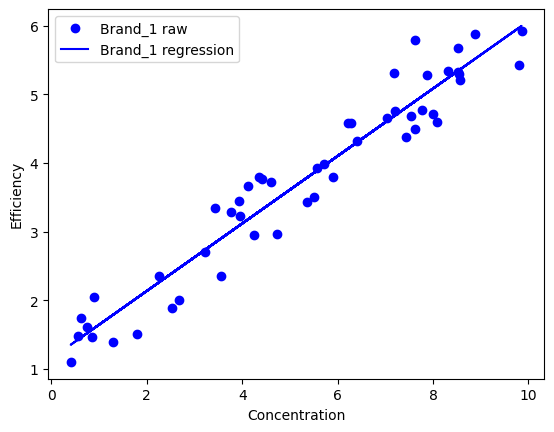

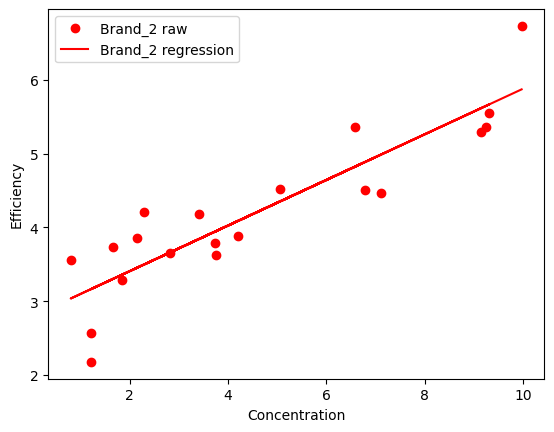

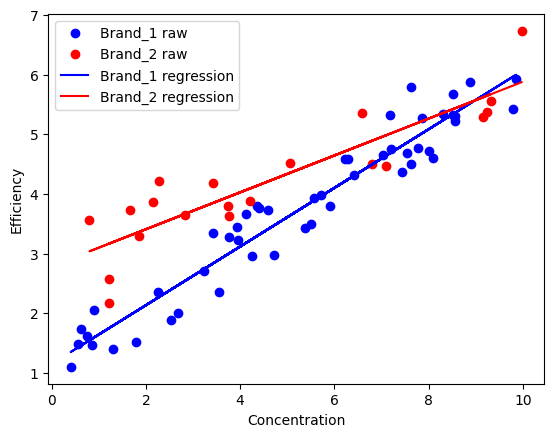

In [12]:
dataframe_brand_1['Efficiency_pred'] = y_pred_brand_1
dataframe_brand_2['Efficiency_pred'] = y_pred_brand_2

ax1 = dataframe_brand_1.plot(x='Concentration', y='Efficiency', style='o', label='Brand_1 raw', color='blue')
dataframe_brand_1.plot(x='Concentration', y='Efficiency_pred', ax=ax1, color='blue', label='Brand_1 regression')
ax1.set_ylabel("Efficiency")

ax2 = dataframe_brand_2.plot(x='Concentration', y='Efficiency', style='o', label='Brand_2 raw', color='red')
dataframe_brand_2.plot(x='Concentration', y='Efficiency_pred', ax=ax2, color='red', label='Brand_2 regression')
ax2.set_ylabel("Efficiency")

ax3 = dataframe_brand_1.plot(x='Concentration', y='Efficiency', style='o', label='Brand_1 raw', color='blue')
dataframe_brand_2.plot(x='Concentration', y='Efficiency', style='o', label='Brand_2 raw', color='red', ax=ax3)
dataframe_brand_1.plot(x='Concentration', y='Efficiency_pred', ax=ax3, color='blue', label='Brand_1 regression')
dataframe_brand_2.plot(x='Concentration', y='Efficiency_pred', ax=ax3, color='red', label='Brand_2 regression')
ax3.set_ylabel("Efficiency")

# Affichage de R2
print('Brand_1 :')
print('R2: ', model_brand_1.score(X_brand_1, y_brand_1))

print('Brand_2 :')
print('R2: ', model_brand_2.score(X_brand_2, y_brand_2))

# Affichage des coefficients de régression
print('Brand_1 :')
print('Coefficients: ', model_brand_1.coef_)
print('Intercept: ', model_brand_1.intercept_)

print('Brand_2 :')
print('Coefficients: ', model_brand_2.coef_)
print('Intercept: ', model_brand_2.intercept_)

<div class="alert alert-info">
Les valeurs de coefficient de détermination montrent que le rendement dépend de la concentration du produit.
En effet, dans les deux cas, on a presque plus de 80% des variations en rendement qui sont expliquées par la concentration.
Il faut toutefois remarquer que cette dépendance est plus marquée pour la marque A que la marque B.

Pour conclure sur la dépendance de la marque, on réalise un test de Bartlett sur les résidus, qui est un test sur la variance d'échantillons tirés de lois normales, ce qui est le cas ici.
Le t-test sur la moyenne est peu utile ici car les deux échantillons ont une moyenne quasiment égale à 0, grâce à l'hypothèse de loi normale centrée.

On réalise un test sur la variance pour vérifier que les comportements des résidus sont différents en fonction de la marque étudiée.
<div>

In [13]:
residuals_brand_1 = y_brand_1 - y_pred_brand_1
residuals_brand_2 = y_brand_2 - y_pred_brand_2

print('Moyenne Brand_1 :', np.mean(residuals_brand_1))
print('Moyenne Brand_2 :', np.mean(residuals_brand_2))
print('')

print('Variance Brand_1 :', np.var(residuals_brand_1))
print('Variance Brand_2 :', np.var(residuals_brand_2))
print('')

print(bartlett(residuals_brand_1, residuals_brand_2))

Moyenne Brand_1 : 2.220446049250313e-16
Moyenne Brand_2 : 3.774758283725532e-16

Variance Brand_1 : 0.12887409752130752
Variance Brand_2 : 0.2216057613258669

BartlettResult(statistic=2.374944755892434, pvalue=0.12329595962023691)


<div class="alert alert-info">
Si on fixe un seuil à 15% (ce qui est plutôt élevé...), on peut conclure que les variances des deux marques sont statistiquement différentes. On peut alors conclure sur la dépendance en la marque étudiée, puisque les deux modèles de régression linéaire présentent des coefficients différents et une distribution des résidus différente.

La deuxième marque présente en effet une dispersion plus grande que la première marque.

Il faut toutefois remarquer que le faible nombre de points ne permet pas de tirer de conclusions définitives.
<div>

## Exercice 2


Nous souhaitons développer une méthode d'apprentissage automatique qui quantifie en temps réel le risque de collision d'un drone avec des objets environnants.

Pour y arriver, nous avons embarqué 18 capteurs sur un drone en phase de test et estimé à plusieurs instants son risque de collision avec un autre objet. Un total de 67 observations labellisées ont été enregistrées dans le fichier *Drone_observations.csv*.

Nous allons évaluer dans cet exercice si ces observations nous permettent de mettre en lien les données capteurs avec le niveau de risque. Nous allons aussi évaluer si nous aurions une bonne performance avec un sous-ensemble pertinent des capteurs. Chaque capteur a en effet un poids non négligeable et a besoin d'énergie pour fonctionner, ce qui a un impact sur le temps d'utilisation du drone entre deux rechargements de ses batteries.  

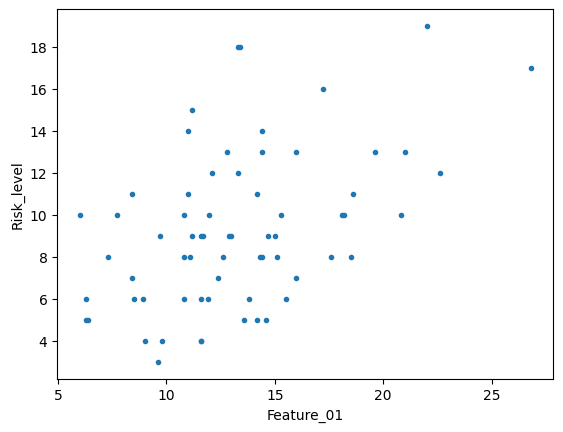

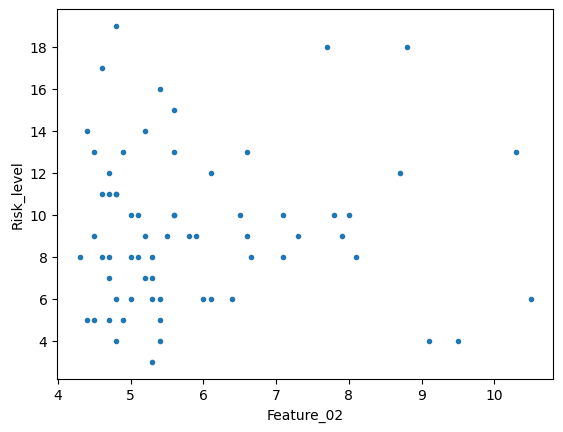

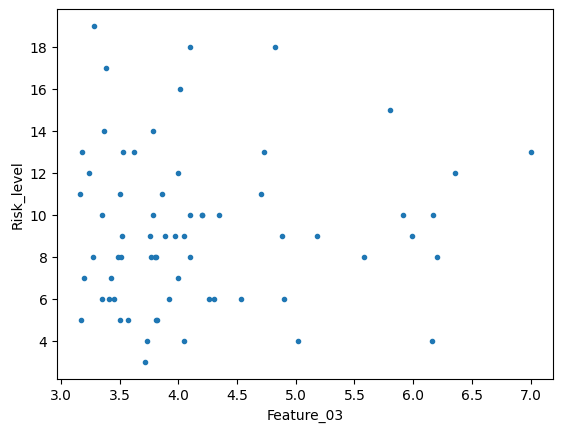

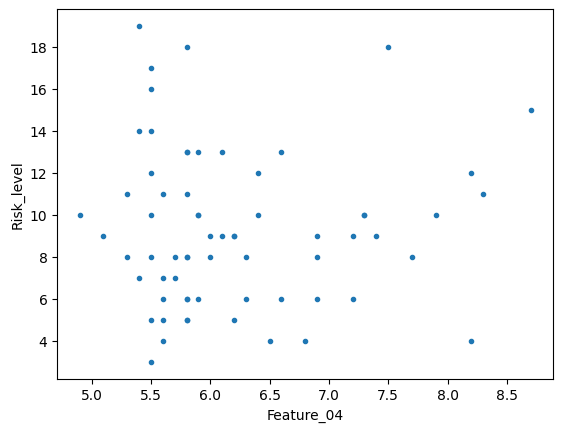

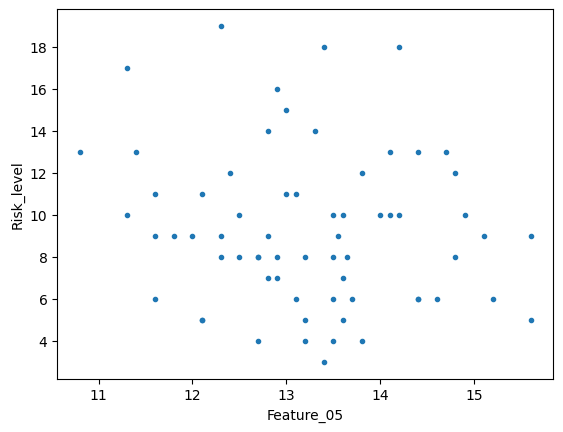

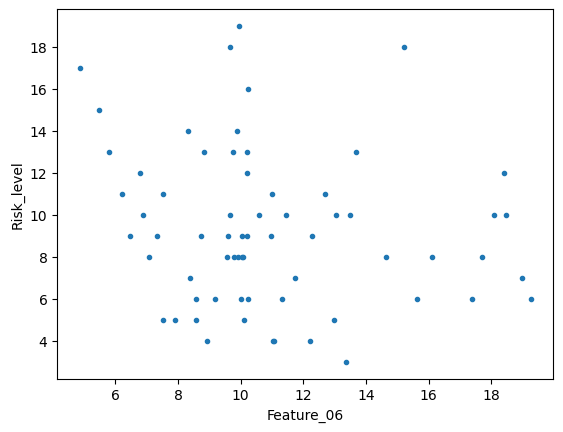

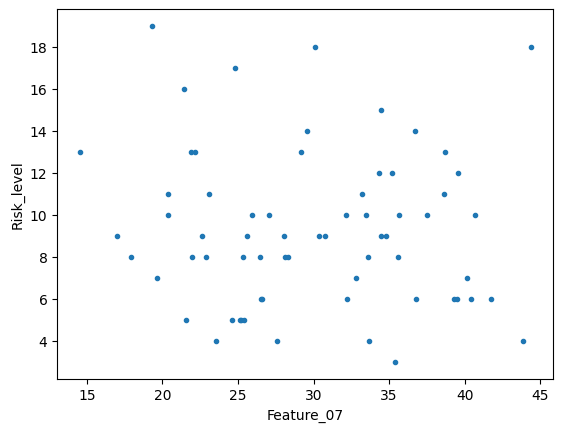

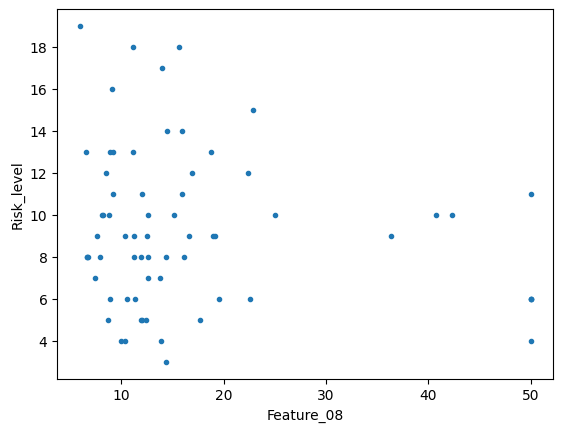

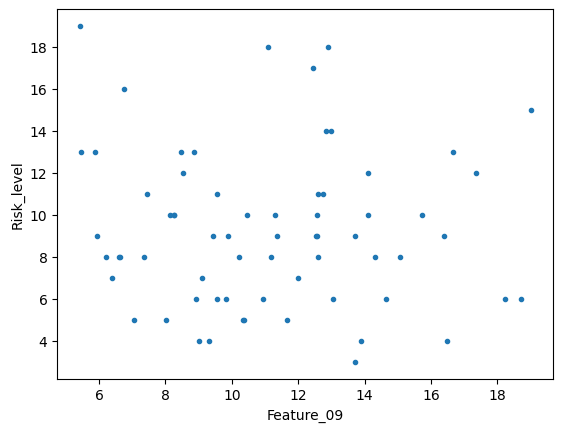

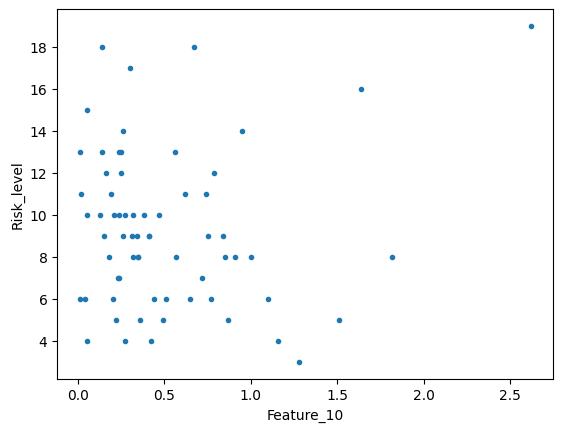

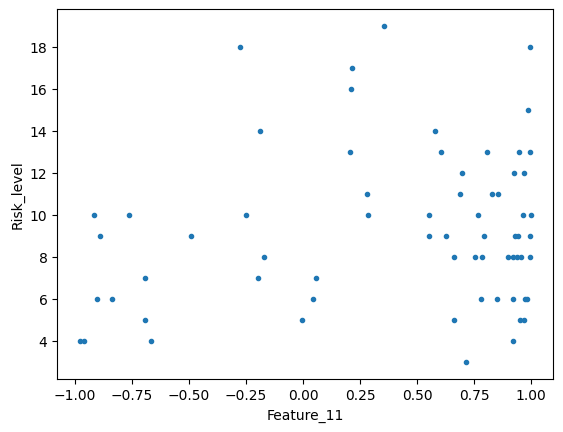

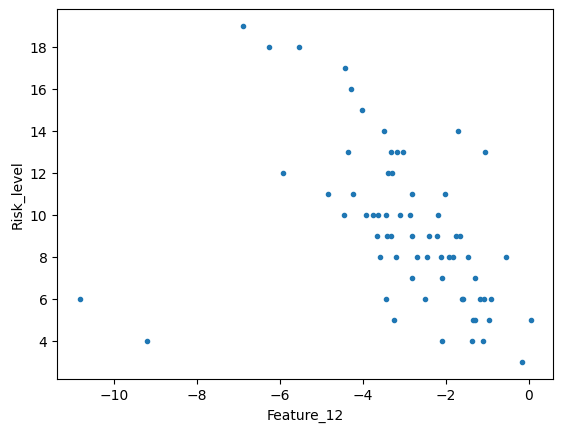

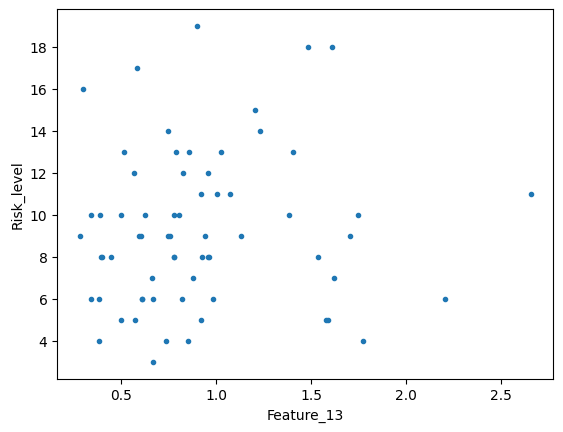

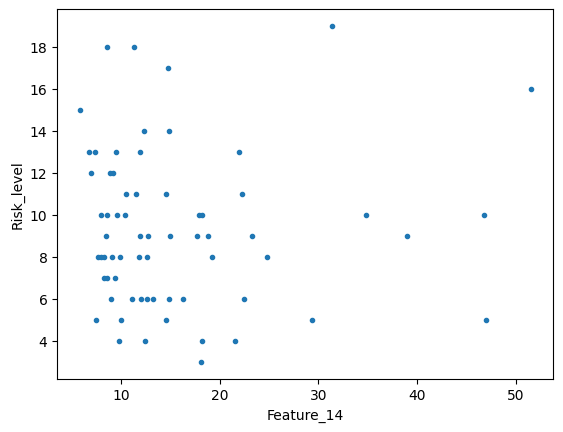

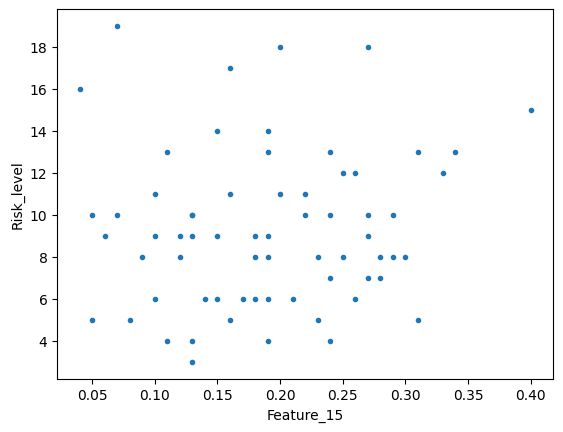

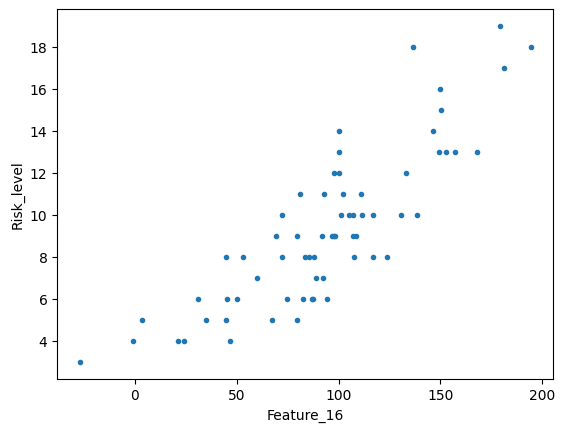

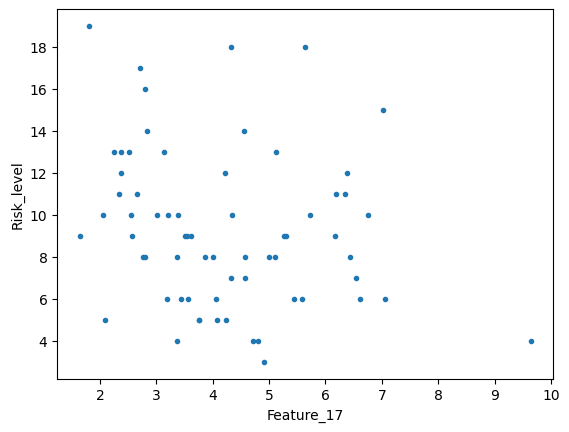

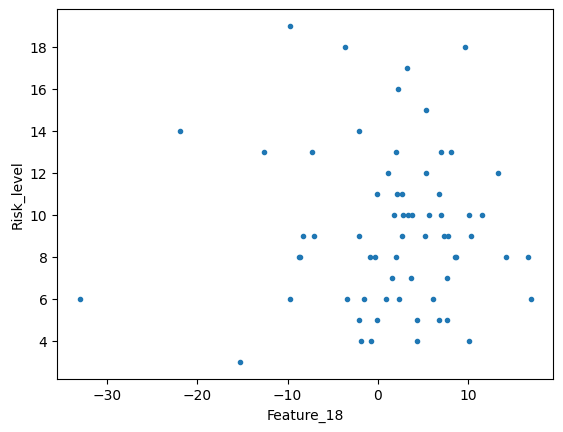

In [14]:
dataframe=pd.read_csv("./Drone_observations.csv",sep=';')

listColNames=list(dataframe.columns)
XY=dataframe.values
ColNb_Y=listColNames.index('Risk_level')

Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

listColNames.pop(ColNb_Y)     #to make it contains the column names of X only

for Col in range(len(listColNames)):
  plt.plot(X[:,Col],Y[:],'.')
  plt.xlabel(listColNames[Col])
  plt.ylabel('Risk_level')
  plt.show()


### QUESTION 2.1

Observez les données unes par unes. Identifiez-vous visuellement des liens entre certaines variables et la variable *Risk_level*. Si oui, lesquels ?


<div class="alert alert-info">
Visuellement, la majorité des nuages de points semblent ne pas présenter de corrélations particulières entre les données.

On remarque tout de même une corrélation linéaire positive pour la feature 16 et la feature 1 (moins marquée), et une corrélation linéaire négative pour la feature 12.
<div>


### QUESTION 2.2
On se demande si il est possible de prédire le niveau de *Risk_level* à partir d'**une seule** des variables *Feature_01*, *Feature_07* ou *Feature_16*.


#### QUESTION 2.2.1
Effectuez une regression linéaire simple entre 'Risk_level' et chacune de ces variables.  Toutes les données seront utilisées pour l'apprentissage. Evaluez alors la qualité des prédictions sur toutes les observations en mesurant l'erreur de prédiction au carré moyenne (MSE). Quel est le risque potentiel en mesurant la qualité des prédictions sur le jeu d'apprentissage ?

#### QUESTION 2.2.2
En utilisant une méthode de validation croisée de type 4-folds, pouvez-vous dire laquelle de ces trois variables semble être la plus fiable pour prédire le risque à l'aide d'un modèle linéaire ?


#### QUESTION 2.2.3
Peut-on statistiquement affirmer qu'il existe une relation significative entre *Risk_level* et (indépendament) *Feature_01*, *Feature_07* ou bien *Feature_16* ? Si oui, décrivez votre procédure de test.


In [15]:
variables = ['Feature_01', 'Feature_07', 'Feature_16']

for variable in variables:
    X = dataframe[variable].values.reshape(-1,1)
    y = dataframe['Risk_level'].values.reshape(-1,1)
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    print('Variable :', variable)
    print('R2: ', model.score(X, y))
    print('Coefficients: ', model.coef_)
    print('Intercept: ', model.intercept_)
    print('MSE: ', mean_squared_error(y, y_pred))
    print('')

Variable : Feature_01
R2:  0.22756273597159693
Coefficients:  [[0.42034504]]
Intercept:  [3.71862545]
MSE:  10.480923895867484

Variable : Feature_07
R2:  0.004548326580904538
Coefficients:  [[-0.03446815]]
Intercept:  [10.31650247]
MSE:  13.506926344682194

Variable : Feature_16
R2:  0.717484844408153
Coefficients:  [[0.07088967]]
Intercept:  [2.65128553]
MSE:  3.833346710573031



<div class="alert alert-info">
Les résutats obtenus semblent confirmer mon a priori visuel précédent, mais il faut être vigilant car la mesure de la qualité sur le jeu d'apprentissage est entâchée du risque de sur-apprentissage. Il faudrait donc valider ces résultats sur un jeu de test indépendant.

On va donc maintenant mener une validation croisée.
<div>

In [16]:
# Validation croisée 4-folds
for variable in variables:
    X = dataframe[variable].values.reshape(-1,1)
    y = dataframe['Risk_level'].values.reshape(-1,1)
    model = LinearRegression()
    kfold = KFold(n_splits=4, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, scoring=make_scorer(mean_squared_error), cv=kfold)
    print('Variable :', variable)
    print('MSE', scores)
    print('')

Variable : Feature_01
MSE [ 8.12648005  7.52962512 11.91560657 15.81290283]

Variable : Feature_07
MSE [11.08715709  9.16290428 15.66580712 21.00220489]

Variable : Feature_16
MSE [3.19393568 1.72323261 3.03688567 8.19705316]



<div class="alert alert-info">
Ceci confirme encore davantage mon a priori visuel, et donc la variable la plus fiable parmi ces 3 variables semble être Feature_16.

Pour répondre à la question suivante, on va réaliser successivement 3 tests de corrélation de Pearson (l'hypothèse nulle étant que les données sont non-corrélées et tirées de lois normales, cf [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)).
<div>

In [17]:
for variable in variables:
    X = dataframe[variable].values.reshape(-1,1)
    y = dataframe['Risk_level'].values.reshape(-1,1)
    print('Variable :', variable)
    print('Pearson correlation coefficient :', pearsonr(X[:,0], y[:,0])[0])
    print('Pearson correlation p-value :', pearsonr(X[:,0], y[:,0])[1])
    print('')

Variable : Feature_01
Pearson correlation coefficient : 0.47703536134294805
Pearson correlation p-value : 5.130502783732586e-05

Variable : Feature_07
Pearson correlation coefficient : -0.06744128246782244
Pearson correlation p-value : 0.5905492065328957

Variable : Feature_16
Pearson correlation coefficient : 0.8470447711946241
Pearson correlation p-value : 3.1624860150064695e-19



<div class="alert alert-info">
Je retrouve ici tout à fait la hiérarchie esquissée dans mon a priori visuel et renforcée par la question précédente.

C'est en effet la feature 16 qui est statistiquement (plus faible p-value et coefficient de Pearson proche de 1) la plus corrélée au risque, suivie par la feature 1.

La feature 7 apparaît elle tout à fait décorrélée du risque.
<div>


### QUESTION 2.3
On s'intéresse maintenant au lien entre les variables *Risk_level* et *Feature_12*. On peut remarquer qu'il semble exister une relation linéaire entre ces variables, mais que les données contiennent aussi deux valeurs aberrantes.


#### QUESTION 2.3.1

Définissez une procédure pour détecter automatiquement les deux données aberrantes dans un jeu de données. Cette procédure fera l'hypothèse que 10\% des observations peuvent ne pas être fiables.

#### QUESTION 2.3.2

Nous supprimerons dans la suite de cet exercice les deux observations qui sont aberrantes sur la variable *Feature_12*. Comment auriez-vous traité ces observations si vous aviez voulu préserver l'information qu'elles contiennent dans les autres variables ?


Text(0, 0.5, 'Risk_level')

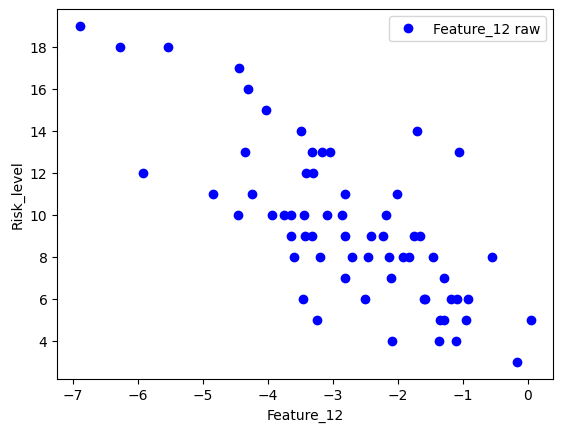

In [18]:
# Procédure pour détecter les outliers avec la méthode des résidus
X = dataframe['Feature_12'].values.reshape(-1,1)
y = dataframe['Risk_level'].values.reshape(-1,1)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

# D'après ma compréhension de l'énoncé, on demande de récupérer dans un jeu de données quelconque les deux outliers. Le nombre d'outliers est donc fixé ici à 2
# Si le nombre d'outliers n'était pas fixé comme dans l'énoncé, on pourrait prendre les 10 pour cent des points ayant les plus grandes valeurs absolues de résidus. Ainsi les deux contraintes de l'énoncé me paraissent antinomiques
indices_tries = np.argsort(np.abs(residuals), axis=0)[::-1]
indices_outliers = indices_tries[:2].reshape(-1)

# Suppression des outliers
dataframe_without_outliers = dataframe.drop(dataframe.index[indices_outliers])

# Affichage des points sans outliers pour Feature_12
ax = dataframe_without_outliers.plot(x='Feature_12', y='Risk_level', style='o', label='Feature_12 raw', color='blue')
ax.set_ylabel("Risk_level")

<div class="alert alert-info">
Pour conserver l'information de ces deux variables, on aurait pu les transformer pour les remettre en phase avec la tendance globale.

On peut par exemple les élever à une certaine puissance (la même pour les deux) ou encore réaliser une modélisation séparée des outliers (surtout utile si on a un nombre non-négligeable d'outliers).
<div>


### QUESTION 2.4

Parmis les 18 variables observées, on souhaite maintenant sélectionner automatiquement celles qui nous permettraient de prédire au mieux *Risk_level* à l'aide de la régression multiple avec un terme de régularisation. Décrivez votre démarche et vos résultats. En particulier, le compromis à trouver entre nombre de variables sélectionnées et qualité de prédiction pourra être discuté.



<div class="alert alert-info">
Je réalise d'abord une régression Ridge, en sélectionnant à la fin les variables dont le coefficient est supérieur à un certain seuil.

Je réalise ensuite une régression Lasso, plus adaptée à la sélection automatique comme nous l'avons vu dans le cours.

J'ai fait le choix de garder un dataset de validation pour estimer la métrique finale. Si on veut uniquement sélectionner les meilleurs hyperparamètres, on peut se passer de cette séparation additionnelle.
<div>

In [19]:
X = dataframe_without_outliers.drop("Risk_level", axis=1)
y = dataframe_without_outliers["Risk_level"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Régression Ridge
alphas = [0.01, 0.1, 1.0, 10.0] 
best_score = np.inf
best_alpha = None
seuil = 0.5

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    mean_score = scores.mean()
    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha

# Entraînement du modèle final avec le meilleure alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Évaluation des performances
y_pred = ridge_model.predict(X_test)

coefficients = ridge_model.coef_

print(f"Meilleur alpha : {best_alpha}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")

# Sélection des variables en fonction des coefficients 
# La sélection est ici menée a posteriori ... ce qui n'est pas idéal et nous motive à utiliser une régression Lasso
selected_features = X.columns[np.abs(coefficients) > seuil]
print("Variables sélectionnées :")
print(selected_features)

Meilleur alpha : 10.0
MSE : 4.795935361805751
Variables sélectionnées :
Index(['Feature_12', 'Feature_16', 'Feature_17'], dtype='object')


/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.532e+01, tolerance: 4.631e-02 Linear regression models with null weight for the l1 regulari

Meilleur alpha : 0.26262626262626265
MSE : 3.1866933117739356


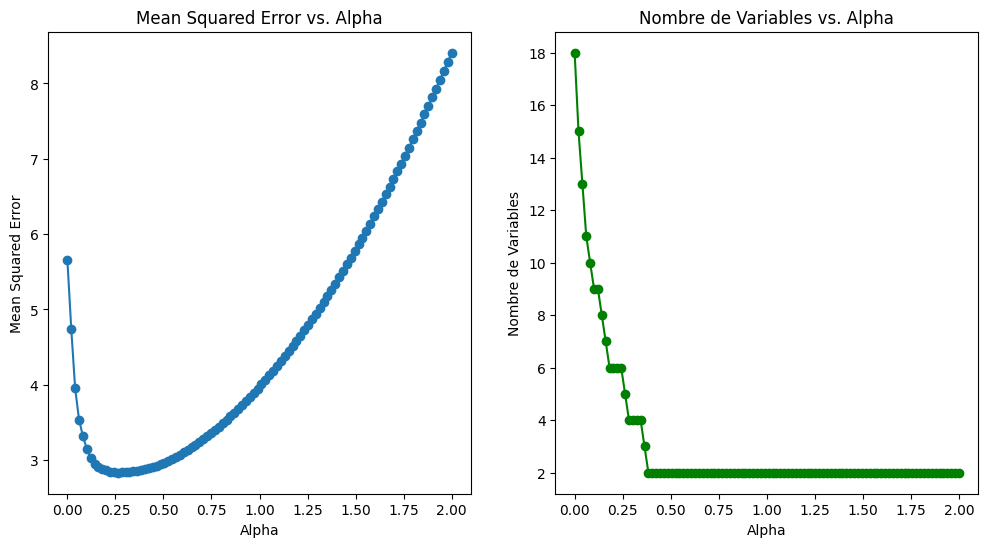

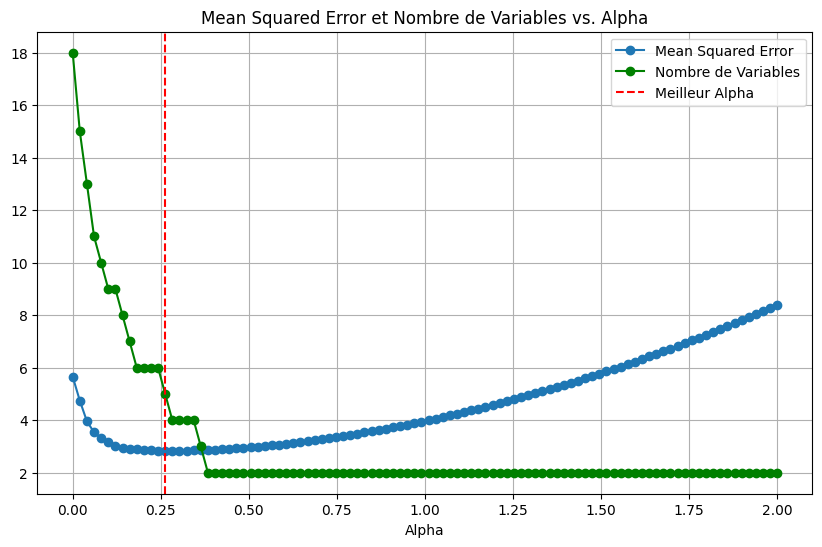

In [20]:
# Régression Lasso
# Première version avec une fenêtre de alpha assez large
alphas = np.linspace(0, 2, 100)
best_score = np.inf
best_alpha = None
scores = []
nombre_variables = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    scores_cv = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    mean_score = scores_cv.mean()
    scores.append(mean_score)
    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha
    lasso_model.fit(X_train, y_train)
    nombre_variables.append(np.sum(np.abs(lasso_model.coef_) > 0))

# Entraînement du modèle final avec le meilleur alpha
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

# Évaluation des performances... j'ai préféré gardé un dataset de validation vierge pour l'évaluation finale du modèle, c'est notamment utile si je voulais comparer les performances de plusieurs modèles
y_pred = lasso_model.predict(X_test)

coefficients = lasso_model.coef_

print(f"Meilleur alpha : {best_alpha}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, scores, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs. Alpha")

plt.subplot(1, 2, 2)
plt.plot(alphas, nombre_variables, marker='o', color='g')
plt.xlabel("Alpha")
plt.ylabel("Nombre de Variables")
plt.title("Nombre de Variables vs. Alpha")

plt.figure(figsize=(10, 6))
plt.plot(alphas, scores, marker='o', label="Mean Squared Error")
plt.plot(alphas, nombre_variables, marker='o', label="Nombre de Variables", color='g')
plt.axvline(x=best_alpha, color='red', linestyle='--', label='Meilleur Alpha')
plt.xlabel("Alpha")
plt.title("Mean Squared Error et Nombre de Variables vs. Alpha")
plt.legend()
plt.grid(True)
plt.show()

/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/accoumar/Desktop/supaero/sdd/algo_ML/BE_StatML_2023/BEvenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.532e+01, tolerance: 4.631e-02 Linear regression models with null weight for the l1 regulari

Meilleur alpha : 0.26262626262626265
MSE : 3.1866933117739356


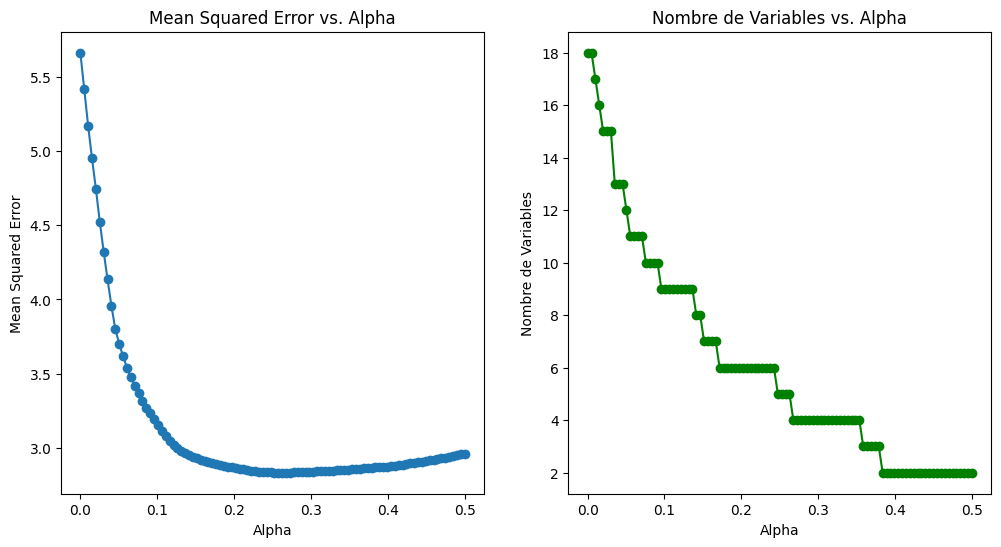

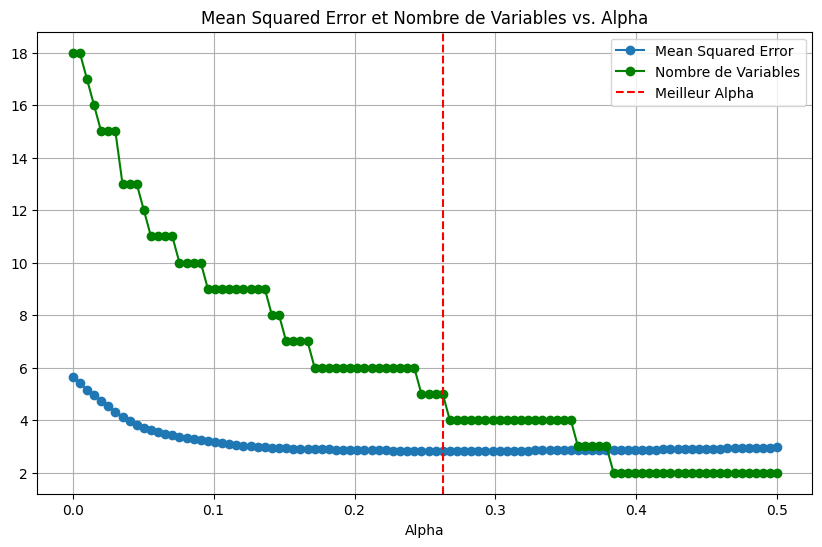

In [21]:
# Deuxième version avec une fenêtre de alpha plus resserrée vers la valeur optimale
alphas = np.linspace(0, 0.5, 100)
best_score = np.inf
best_alpha = None
scores = []
nombre_variables = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    scores_cv = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    mean_score = scores_cv.mean()
    scores.append(mean_score)
    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha
    lasso_model.fit(X_train, y_train)
    nombre_variables.append(np.sum(np.abs(lasso_model.coef_) > 0))

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

coefficients = lasso_model.coef_

print(f"Meilleur alpha : {best_alpha}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, scores, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs. Alpha")

plt.subplot(1, 2, 2)
plt.plot(alphas, nombre_variables, marker='o', color='g')
plt.xlabel("Alpha")
plt.ylabel("Nombre de Variables")
plt.title("Nombre de Variables vs. Alpha")

plt.figure(figsize=(10, 6))
plt.plot(alphas, scores, marker='o', label="Mean Squared Error")
plt.plot(alphas, nombre_variables, marker='o', label="Nombre de Variables", color='g')
plt.axvline(x=best_alpha, color='red', linestyle='--', label='Meilleur Alpha')
plt.xlabel("Alpha")
plt.title("Mean Squared Error et Nombre de Variables vs. Alpha")
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-info">
C'est beaucoup mieux avec la régression Lasso !

On voit en effet qu'il s'agit de trouver un compromis entre la qualité de la prédiction et le nombre de variables sélectionnées.

On voit en effet qu'avec seulement deux variables, on arrive à atteindre des performances proches de l'optimal.
Ce dernier est atteint lorsque seulement 5 variables sont sélectionnées.
<div>